<p>
    Stars rating ~ text words 
</p>
<p>
    -  BALANCING THE TRAINING DATA (SMOTE)
</p>

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Collecting the data

In [2]:
reviews = pd.read_csv('data/yelp_cleveland_reviews.csv')

In [3]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,Jdqg97lLo_qJlCqU9RjIEA,1,2012-09-08,1,Bz5kR052DviDGQGV_q8VUQ,3,Dipped cone all the way! This location is tric...,1,j5yfS1QjGwNLQ0h4_wDyxg
1,Jdqg97lLo_qJlCqU9RjIEA,1,2016-09-17,1,Sc2eLc1kTsehqraMhrT1zg,5,Always amazing food and service. Love their ch...,0,dk8-B6hKb1XOmYJKC4Ig3Q
2,Jdqg97lLo_qJlCqU9RjIEA,0,2016-07-21,0,Qpz73uZ60Gk7MSKbD6Y6_A,1,This place is literally the worst. Hopefully t...,0,9RG87QSBaTmcbDu3ydQJ2g
3,Jdqg97lLo_qJlCqU9RjIEA,0,2017-01-28,1,NdjK8rttbevfoDwgXcL-eg,3,Very nice and new. Staff is always friendly bu...,0,y6IogOYLjAs8Mksx62vnDQ
4,Jdqg97lLo_qJlCqU9RjIEA,0,2014-01-17,0,2PoRWtHb6ulqr8AJv_QGhA,3,"Nothing special about this place, their ice cr...",0,VKwI11qTXOxHmlh2yr_2TQ


In [4]:
reviews.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

In [6]:
reviews.isna().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91057 entries, 0 to 91056
Data columns (total 9 columns):
business_id    91057 non-null object
cool           91057 non-null int64
date           91057 non-null datetime64[ns]
funny          91057 non-null int64
review_id      91057 non-null object
stars          91057 non-null int64
text           91057 non-null object
useful         91057 non-null int64
user_id        91057 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 6.3+ MB


## Selecting the data to work on

In [3]:
data = reviews[['stars', 'text']] 
#data = reviews[['stars', 'text', 'cool', 'useful', 'funny']] 

In [4]:
data.head()

,stars,text
0,3,Dipped cone all the way! This location is tric...
1,5,Always amazing food and service. Love their ch...
2,1,This place is literally the worst. Hopefully t...
3,3,Very nice and new. Staff is always friendly bu...
4,3,"Nothing special about this place, their ice cr..."


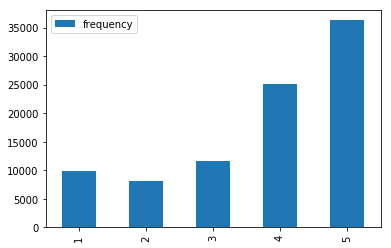

In [5]:
def plot_stars_frequencies(df):
    new_df = pd.DataFrame(df['stars'].value_counts())
    new_df.columns =['frequency']
    new_df = new_df.sort_index(ascending=True)
    new_df.plot(kind='bar')

plot_stars_frequencies(data)

## Subsample the data

In [6]:
# We're going to work only on a random sample of size=15000, due to computational constraints.
sample_size = 15000
sample = data.sample(sample_size)
sample = sample.reset_index(drop=True)

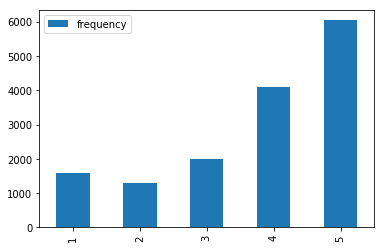

In [7]:
plot_stars_frequencies(sample)

## Data cleaning

### Removing punctuation


In [8]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [9]:
# Apply remove_punctuation to each row of data['text'] 
sample['text'] = sample['text'].apply(remove_punctuation)

### Removing stopwords


In [10]:
def remove_stopwords(text):
    from nltk.corpus import stopwords
    '''a function for removing the stopword'''
    sw = stopwords.words('english')
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [11]:
# Apply remove_stopwords to each row of data['text'] 
sample['text'] = sample['text'].apply(remove_stopwords)

### Stemming words


In [12]:
def stemming(text): 
    '''a function which stems each word in the given text'''
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [13]:
# Apply remove_punctuation to each row of data['text'] 
sample['text'] = sample['text'].apply(stemming)

## TF-IDF


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create a count vectorizer object
vectorizer = TfidfVectorizer(dtype=np.float32)
# fit the count vectorizer using the text data
tfidf_matrix = vectorizer.fit_transform(sample['text'].values)

print(len(vectorizer.get_feature_names()))


28564


In [15]:
def get_word_freq(tfidf, vectorizer):
    return sorted([(tfidf.getcol(idx).sum(), word)
                   for word, idx in vectorizer.vocabulary_.items()],
                  reverse=True)

words_tfidf_scores = get_word_freq(tfidf_matrix, vectorizer) # matrix of each word and its tfidf score

In [16]:
# transform tfidf scores matrix into pandas dataframe
words_tfidf_scores_df = pd.DataFrame(words_tfidf_scores, dtype=np.float32) 
words_tfidf_scores_df.columns = ['tfidf_score', 'token']
words_tfidf_scores_df = words_tfidf_scores_df.set_index('token')

### Infos about 'words_tfidf_scores' dataframe

In [19]:
words_tfidf_scores_df.head()

,tfidf_score
token,
food,487.682251
great,469.493164
place,461.781891
good,452.332611
servic,324.718872


In [20]:
words_tfidf_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28640 entries, food to partsservic
Data columns (total 1 columns):
tfidf_score    28640 non-null float32
dtypes: float32(1)
memory usage: 335.6+ KB


In [22]:
words_tfidf_scores_df.shape

(28470, 1)

### Histogram of the 100 highest

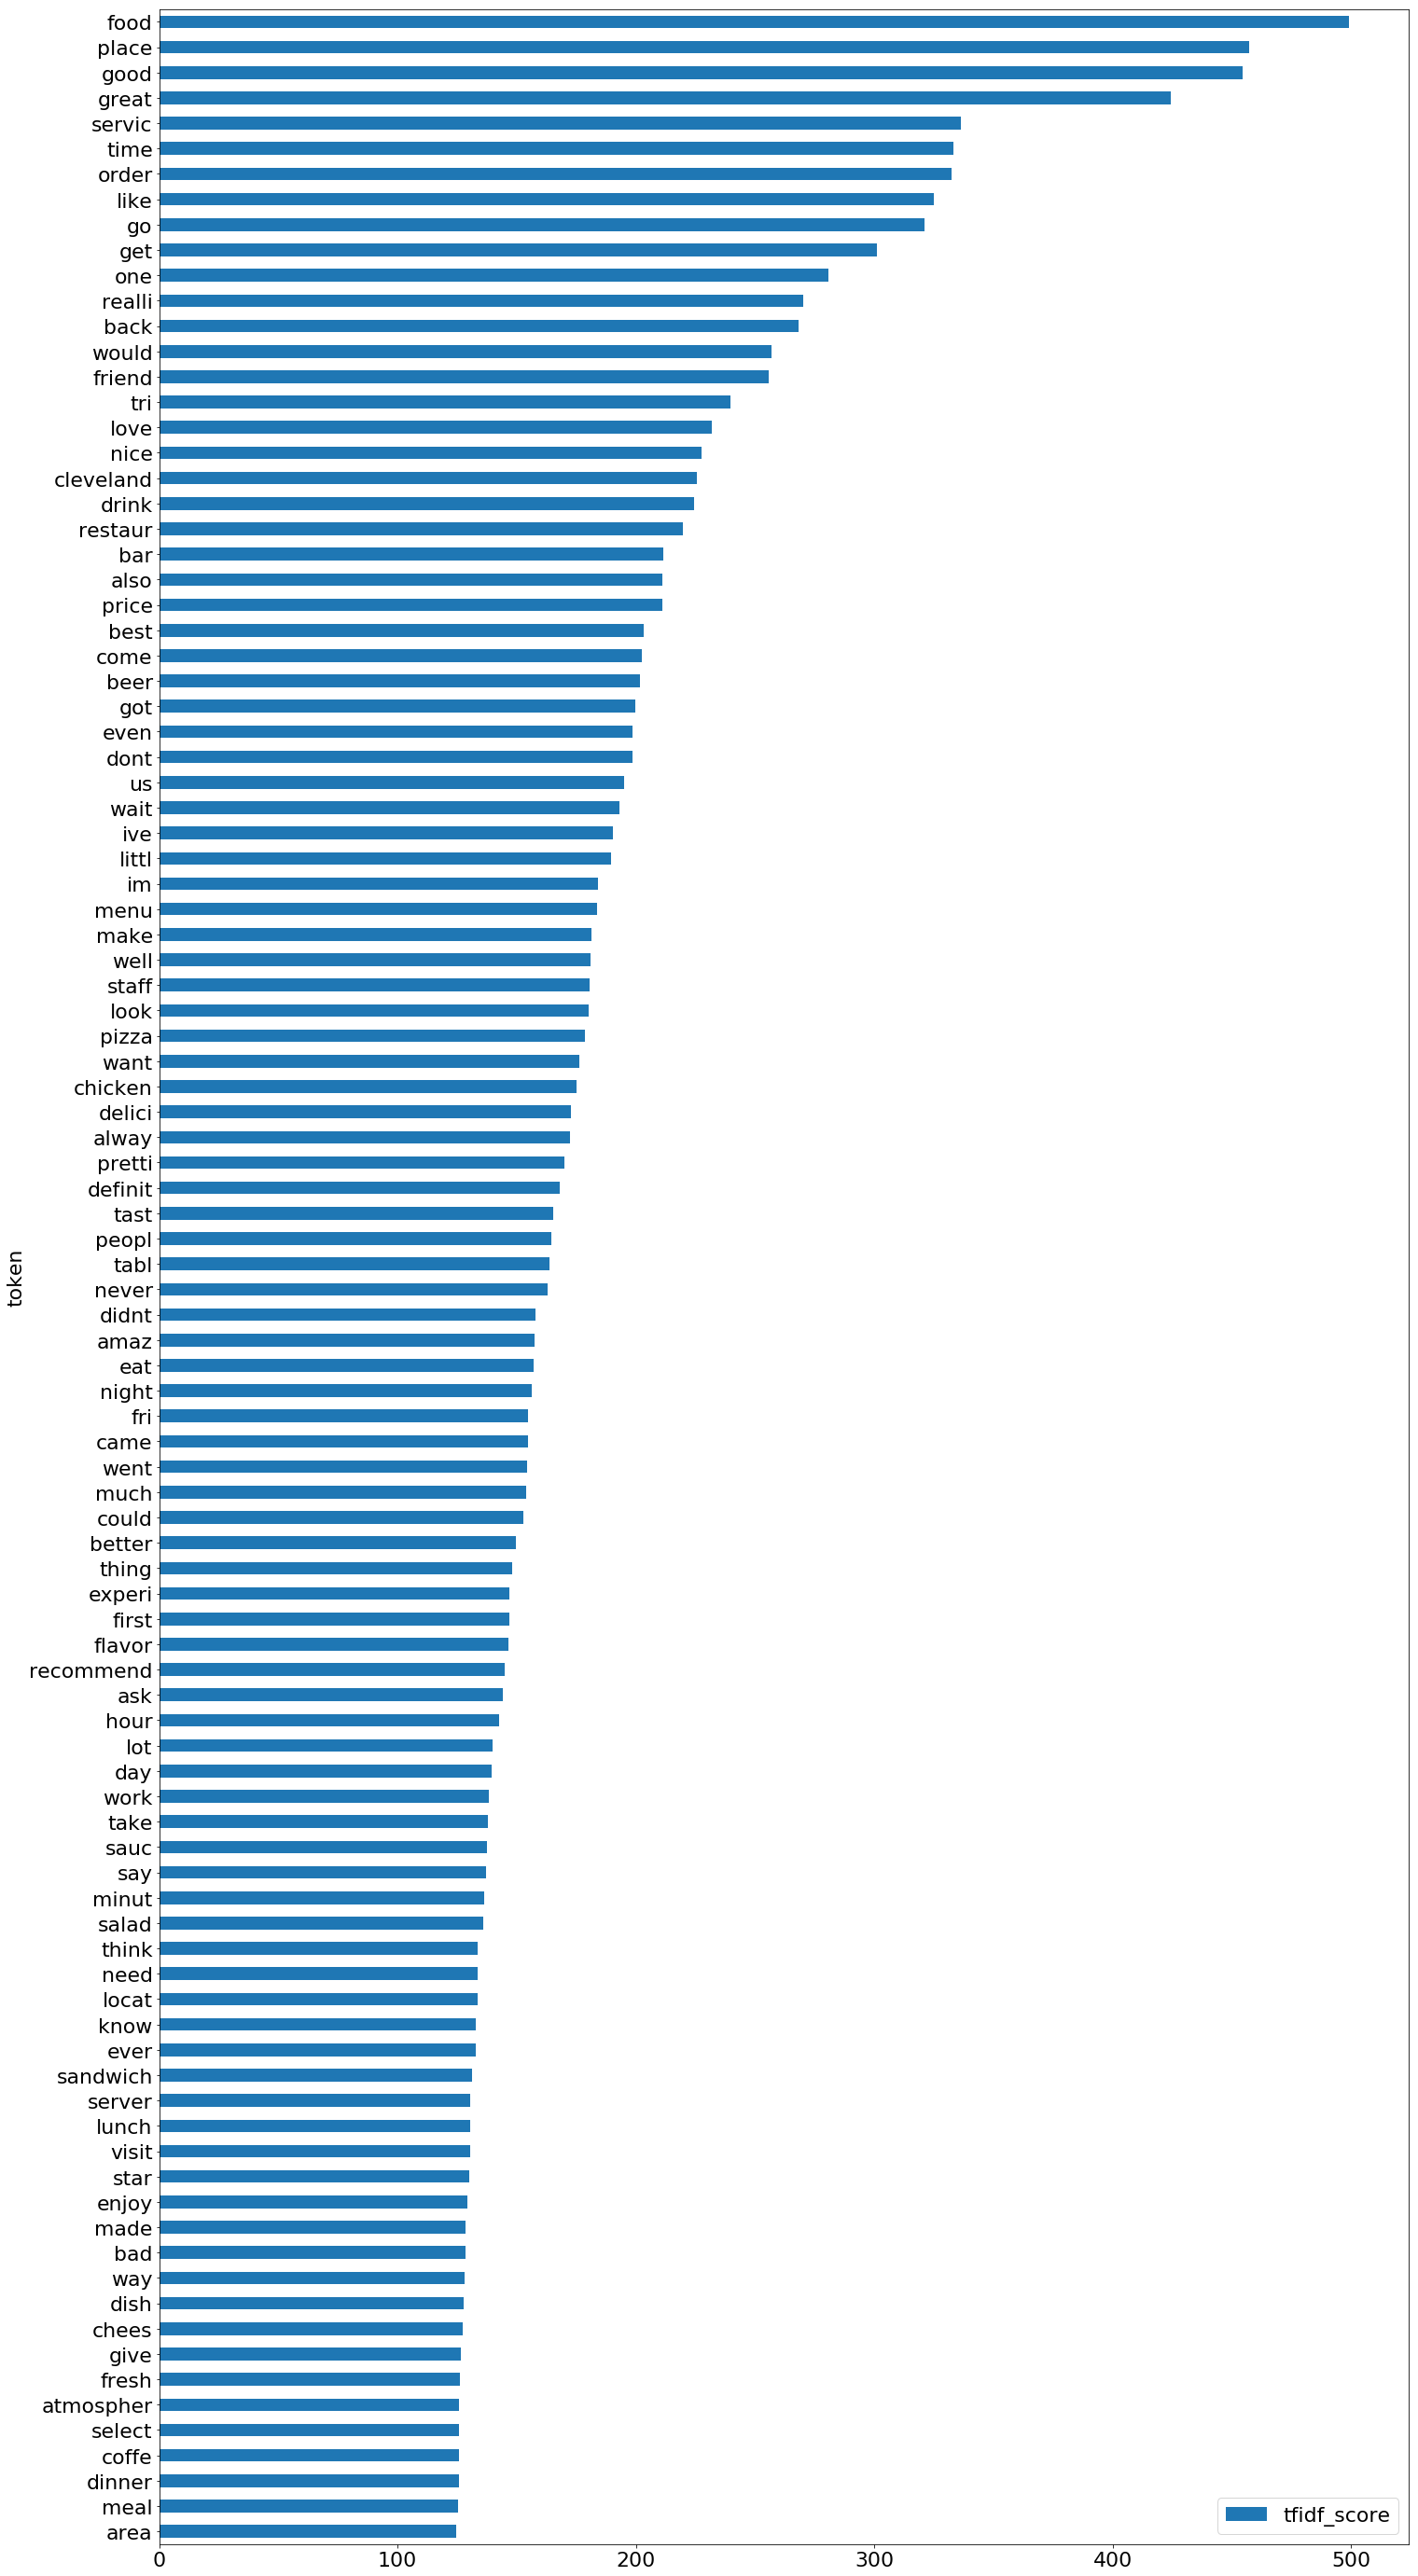

In [44]:
plt.rcParams['figure.figsize'] = (24, 50)
plt.rcParams['font.size'] = 22
ax = words_tfidf_scores_df.head(100).plot(kind='barh')
ax.invert_yaxis()

### Histogram the 100 lowest 

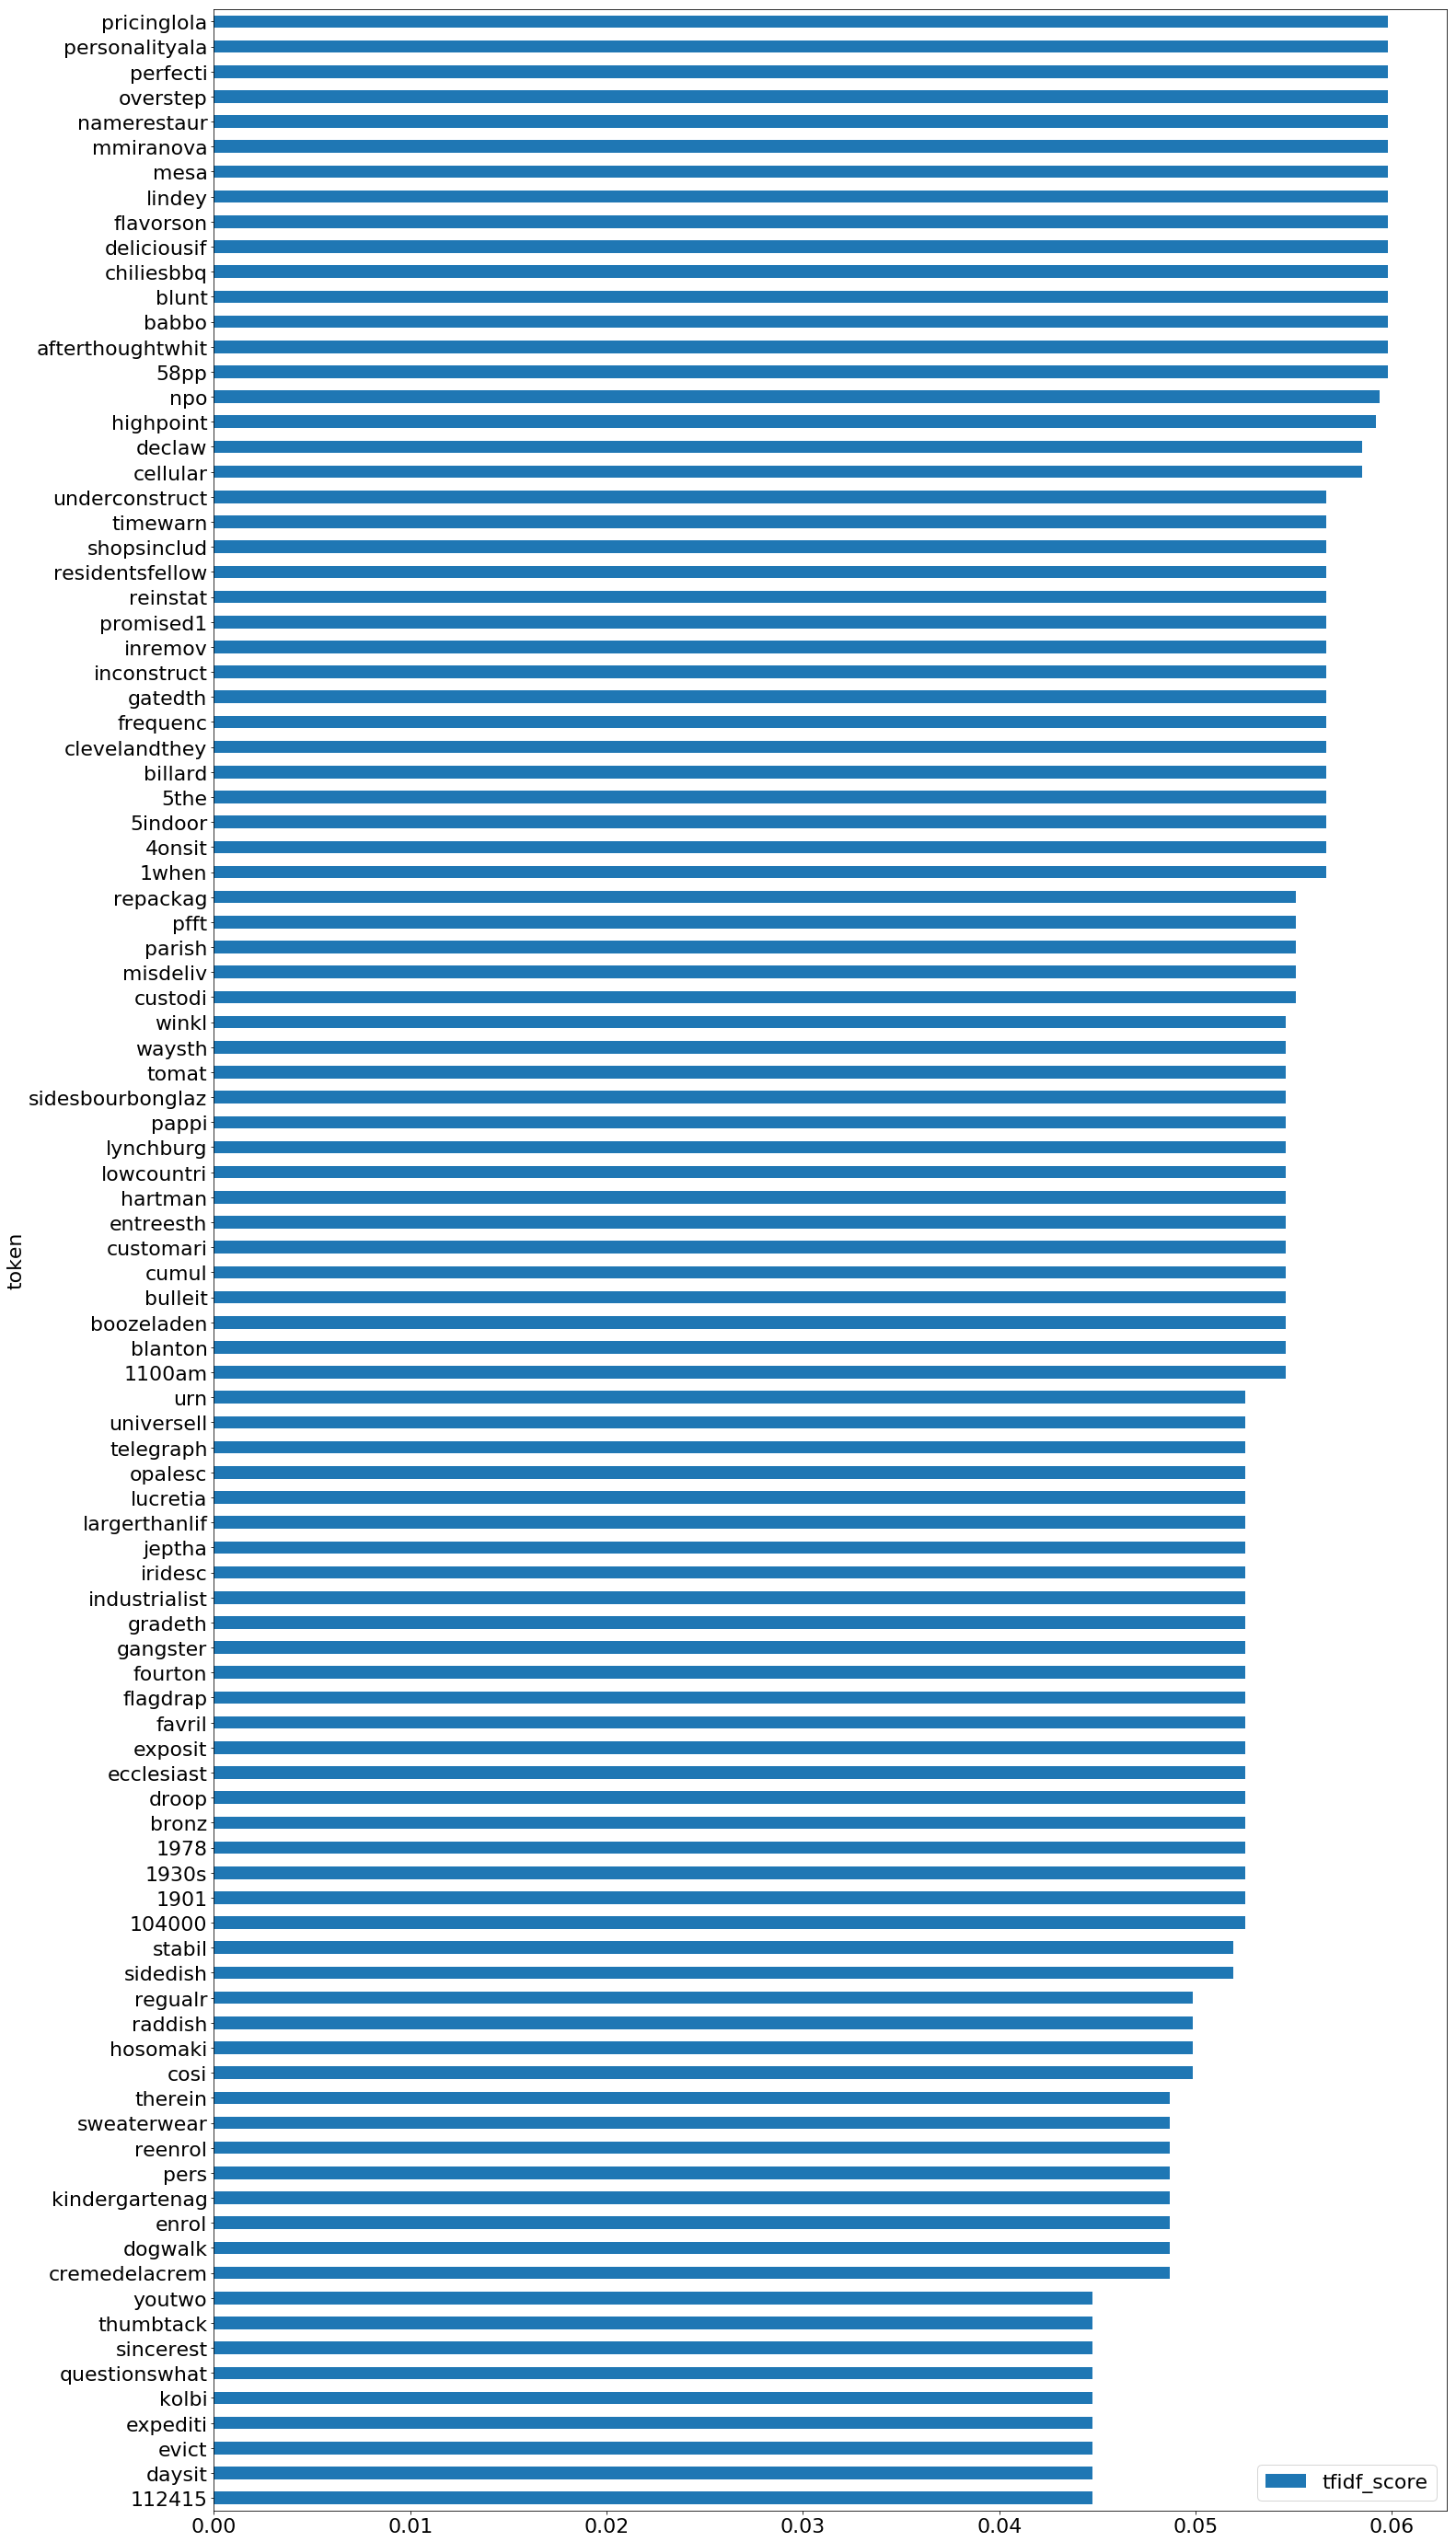

In [46]:
plt.rcParams['figure.figsize'] = (24, 50)
plt.rcParams['font.size'] = 22
ax = words_tfidf_scores_df.tail(100).plot(kind='barh')
ax.invert_yaxis()

## Features selection and creating the final dataframe for the training phase with respect to the features that've been selected

In [18]:
def getKey(dict, value):
    '''get dictionnary key from its value'''
    
    return [key for key in dict.keys() if (dict[key] == value)][0] #Because a value can't be present in multiple keys


In [28]:
#total_words = len(words_tfidf_scores_df)
#features_size = int(total_words * 0.2)
top_features_size = 1001

top_features_names = words_tfidf_scores_df.index.values[:top_features_size] # Extracting the top 20% features' names

# And their corresponding indices from the 'vectorizer.vocabulary_' dictionnary
top_features_indices = [
    vectorizer.vocabulary_.get(top_features_names[i]) for i in range(len(top_features_names))
]

# Creating the final dataframe from the tfidf_matrix with respect to the top features
final_df = pd.DataFrame()

for top_feature_index in top_features_indices:
    final_df[getKey(vectorizer.vocabulary_, top_feature_index)] = pd.Series(tfidf_matrix.getcol(top_feature_index).toarray().ravel())

final_df['stars'] = sample['stars']
final_df.head()

,food,place,great,good,time,servic,go,like,order,get,...,odd,vendor,multipl,block,chipotl,oyster,dim,similar,posit,stars
0,0.000000,0.114153,0.041230,0.000000,0.045216,0.000000,0.044555,0.0,0.0,0.045870,...,0.0,0.0,0.112206,0.000000,0.0,0.0,0.0,0.0,0.0,5
1,0.060685,0.000000,0.064892,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4
2,0.166565,0.082189,0.000000,0.000000,0.000000,0.101004,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.029066,0.031495,0.000000,0.034540,0.000000,0.000000,0.0,0.0,0.035039,...,0.0,0.0,0.000000,0.086423,0.0,0.0,0.0,0.0,0.0,3
4,0.075397,0.000000,0.000000,0.077118,0.000000,0.091441,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5


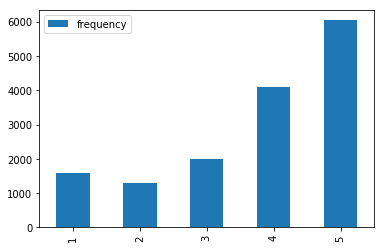

In [30]:
plot_stars_frequencies(final_df)

## Model fitting

### Utility functions

In [22]:
def pretty_print_cm(cm, labels, normalize=False):
    """pretty print confusion matrices"""
    import seaborn as sns
    from sklearn.preprocessing import scale
    
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = ' '.join(['Normalized', title])
    
    conf_mat = pd.DataFrame(cm, columns=labels, index=labels)
    conf_mat.index.name = 'True \ Predicted'
    ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    plt.show()

In [23]:
def generate_prediction_results(y_true, y_pred):
    """generate classification report and confusion matrix on a given true and predicted values"""
    from sklearn.metrics import classification_report, confusion_matrix

    conf_mat = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, output_dict=True)
    return conf_mat, class_report

### Train/Test split
<p>The training error is included in order to check for overfitting</p>

In [87]:
from sklearn.model_selection import train_test_split

X = final_df.drop(['stars'], 1)
y = final_df['stars']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)


##### Balancing the training set

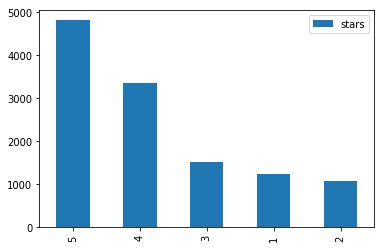

In [88]:
# Visualizing the training set imbalanced data
pd.DataFrame(y_train.value_counts()).plot(kind='bar')

In [100]:
# Balancing the training set before training the models
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x_cols = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=x_cols)
y_train = pd.Series(y_train)

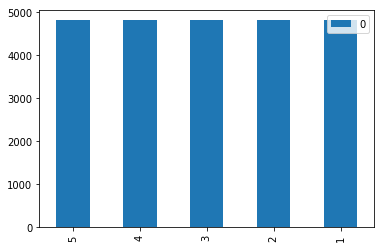

In [101]:
# Visualizing the training set imbalanced data
pd.DataFrame(y_train.value_counts()).plot(kind='bar')

#### Naive Bayes

In [103]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
NB_predictions_test = clf.predict(X_test)
NB_predictions_train = clf.predict(X_train)

##### Prediction results

In [105]:
NB_confusion_matrix_test, NB_classification_report_test = generate_prediction_results(y_test, NB_predictions_test)
NB_confusion_matrix_train, NB_classification_report_train = generate_prediction_results(y_train, NB_predictions_train)

<p><b>On the training set:</b></p>

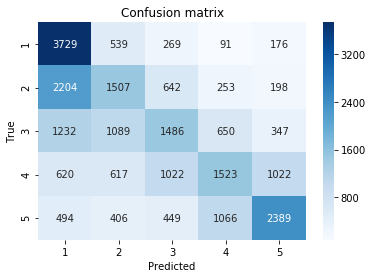

In [106]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(NB_confusion_matrix_train, labels)

In [107]:
# classification report
pd.DataFrame(NB_classification_report_train)

,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.570053,0.336309,0.342712,0.363181,0.534691,0.429389,0.442714,0.429389
precision,0.450417,0.362434,0.384178,0.425063,0.578170,0.440052,0.442714,0.440052
recall,0.776228,0.313697,0.309326,0.317027,0.497294,0.442714,0.442714,0.442714
support,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,24020.000000,24020.000000,24020.000000


<p><b>On the test set:</b></p>

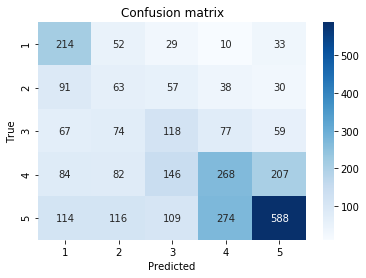

In [108]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(NB_confusion_matrix_test, labels)

In [109]:
# Classification report
print('Classification report: \n')
pd.DataFrame(NB_classification_report_test)

Classification report: 



,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.471366,0.189189,0.276347,0.368638,0.555241,0.372156,0.417,0.426075
precision,0.375439,0.162791,0.257081,0.401799,0.641221,0.367666,0.417,0.453395
recall,0.633136,0.225806,0.298734,0.340534,0.489592,0.397560,0.417,0.417000
support,338.000000,279.000000,395.000000,787.000000,1201.000000,3000.000000,3000.000,3000.000000


#### Multinomial Naive Bayes

In [124]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
MNB_predictions_train = clf.predict(X_train)
MNB_predictions_test = clf.predict(X_test)

##### Prediction results

<p><b>On the training set</b></p>

In [127]:
MNB_confusion_matrix_train, MNB_classification_report_train = generate_prediction_results(y_train, MNB_predictions_train)

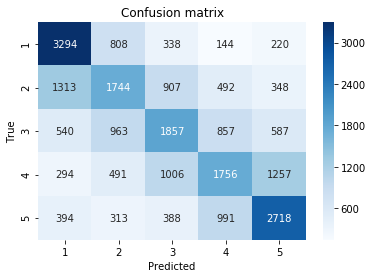

In [128]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(MNB_confusion_matrix_train, labels)

In [129]:
# Classification report
pd.DataFrame(MNB_classification_report_train)

,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.619231,0.382330,0.399355,0.388324,0.547212,0.467290,0.473314,0.467290
precision,0.564524,0.403797,0.413034,0.414151,0.529825,0.465066,0.473314,0.465066
recall,0.685679,0.363031,0.386553,0.365529,0.565779,0.473314,0.473314,0.473314
support,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,24020.000000,24020.000000,24020.000000


<p><b>On the test set</b></p>

In [130]:
MNB_confusion_matrix_test, MNB_classification_report_test = generate_prediction_results(y_test, MNB_predictions_test)

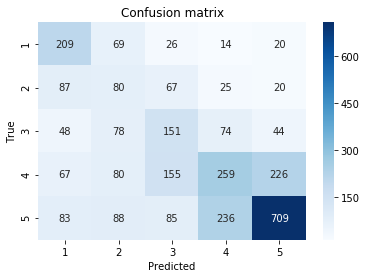

In [132]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(MNB_confusion_matrix_test, labels)

In [133]:
# Classification report
pd.DataFrame(MNB_classification_report_test)

,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.502404,0.237389,0.343572,0.371326,0.638739,0.418686,0.469333,0.477038
precision,0.423077,0.202532,0.311983,0.425987,0.695780,0.411872,0.469333,0.497874
recall,0.618343,0.286738,0.382278,0.329098,0.590341,0.441360,0.469333,0.469333
support,338.000000,279.000000,395.000000,787.000000,1201.000000,3000.000000,3000.000000,3000.000000


#### Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
clf.fit(X_train, y_train)

LR_predictions_train = clf.predict(X_train)
LR_predictions_test = clf.predict(X_test)

##### Prediction results

<p><b>On the training set:</b></p>


In [111]:
LR_confusion_matrix_train, LR_classification_report_train = generate_prediction_results(y_train, LR_predictions_train)

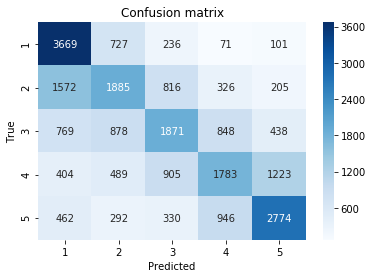

In [112]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(LR_confusion_matrix_train, labels)

In [113]:
pd.DataFrame(LR_classification_report_train)

,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.628253,0.415427,0.417541,0.406243,0.581247,0.489742,0.498834,0.489742
precision,0.533595,0.441349,0.449976,0.448666,0.585109,0.491739,0.498834,0.491739
recall,0.763739,0.392381,0.389467,0.371149,0.577435,0.498834,0.498834,0.498834
support,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,24020.000000,24020.000000,24020.000000


<p><b>On the test set:</b></p>


In [114]:
LR_confusion_matrix_test, LR_classification_report_test = generate_prediction_results(y_test, LR_predictions_test)

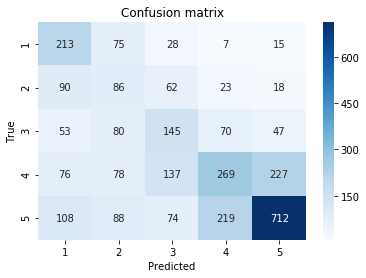

In [115]:
# Confusion matrix
labels = [1, 2, 3, 4, 5]
pretty_print_cm(LR_confusion_matrix_test, labels)

In [116]:
pd.DataFrame(LR_classification_report_test)

,1,2,3,4,5,macro avg,micro avg,weighted avg
f1-score,0.485194,0.250729,0.344828,0.391273,0.641441,0.422693,0.475,0.482820
precision,0.394444,0.211302,0.325112,0.457483,0.698724,0.417413,0.475,0.506634
recall,0.630178,0.308244,0.367089,0.341804,0.592839,0.448031,0.475,0.475000
support,338.000000,279.000000,395.000000,787.000000,1201.000000,3000.000000,3000.000,3000.000000


### Cross Validation

#### Balancing cross validation data

In [39]:
X = final_df.drop(['stars'], 1)
y = final_df['stars']

In [40]:
# Balancing the training set before training the models
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x_cols = X.columns
X, y = sm.fit_sample(X, y)
X = pd.DataFrame(X, columns=x_cols)
y = pd.Series(y)

#### Naive Bayes

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB

cv = StratifiedKFold(n_splits=10, shuffle=True)

clf = GaussianNB()
NB_cv_results = cross_validate(clf, X, y, cv=cv, return_train_score=True, scoring='f1_weighted')

In [56]:
print('CV training score: ', np.mean(NB_cv_results['train_score']))
print('CV test score: ', np.mean(NB_cv_results['test_score']))

CV training score:  0.5647099553500972
CV test score:  0.529737515805589


#### MULTINOMIAL NAIVE BAYES

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

cv = StratifiedKFold(n_splits=10, shuffle=True)

clf = MultinomialNB()
MNB_cv_results = cross_validate(clf, X, y, cv=cv, return_train_score=True, scoring='f1_weighted')

In [46]:
print('CV training score: ', np.mean(MNB_cv_results['train_score']))
print('CV test score: ', np.mean(MNB_cv_results['test_score']))

CV training score:  0.6792384489497849
CV test score:  0.6564647109293623
